### Advanced Business Analytics - SEGMENTATION with Olist Dataset


[Datasets](https://www.kaggle.com/olistbr/brazilian-ecommerce)

<img src="https://i.imgur.com/HRhd2Y0.png" />

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Read the data
dt_orders = pd.read_csv('/content/drive/My Drive/projekt ZAB/olist_orders_dataset.csv', parse_dates=True)
dt_pay = pd.read_csv('/content/drive/My Drive/projekt ZAB/olist_order_payments_dataset.csv', parse_dates=True)
dt_rev = pd.read_csv('/content/drive/My Drive/projekt ZAB/olist_order_reviews_dataset.csv', parse_dates=True)
dt_items = pd.read_csv('/content/drive/My Drive/projekt ZAB/olist_order_items_dataset.csv', parse_dates=True)
dt_prod = pd.read_csv('/content/drive/My Drive/projekt ZAB/olist_products_dataset.csv', parse_dates=True)
dt_cust = pd.read_csv('/content/drive/My Drive/projekt ZAB/olist_customers_dataset.csv', parse_dates=True)
dt_translation = pd.read_csv('/content/drive/My Drive/projekt ZAB/product_category_name_translation.csv', parse_dates=True)

# joins
dt1 = pd.merge(dt_orders, dt_pay, on='order_id',how='inner')
dt2 = pd.merge(dt1, dt_rev, on='order_id',how='outer')
dt_ord = pd.merge(dt2, dt_items, on='order_id',how='outer')

dt_cust = dt_cust.rename(columns={"customer_zip_code_prefix": "zip_code"}) 

dt3 = pd.merge(dt_ord, dt_prod, on='product_id',how='outer')
dt4 = pd.merge(dt3, dt_cust, on='customer_id',how='outer')
dt5 = dt4.drop(columns=['review_comment_title','review_comment_message'])

data = pd.merge(dt5, dt_translation, on='product_category_name',how='left')
data = data.drop(columns=["product_category_name"])

In [ ]:
data.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'review_id', 'review_score', 'review_creation_date',
       'review_answer_timestamp', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'customer_unique_id', 'zip_code', 'customer_city', 'customer_state',
       'product_category_name_english'],
      dtype='object')

In [ ]:
data.shape

(119152, 34)

In [ ]:
data.head(10)

order_id  ... product_category_name_english
0  e481f51cbdc54678b7cc49136f2d6af7  ...                    housewares
1  e481f51cbdc54678b7cc49136f2d6af7  ...                    housewares
2  e481f51cbdc54678b7cc49136f2d6af7  ...                    housewares
3  128e10d95713541c87cd1a2e48201934  ...                    housewares
4  0e7e841ddf8f8f2de2bad69267ecfbcf  ...                    housewares
5  bfc39df4f36c3693ff3b63fcbea9e90a  ...                    housewares
6  53cdb2fc8bc7dce0b6741e2150273451  ...                     perfumery
7  40c5e18f7d112b59b3e5113a59a905b3  ...                     perfumery
8  86674ccaee19790309333210917b2c7d  ...                     perfumery
9  f913d229653fdd809c249ed98ab6b754  ...                     perfumery

[10 rows x 34 columns]

In [ ]:
for e in enumerate(data["order_status"].unique()):
    print(e)

(0, 'delivered')
(1, 'shipped')
(2, 'invoiced')
(3, 'canceled')
(4, 'processing')
(5, 'unavailable')
(6, 'created')
(7, nan)
(8, 'approved')


In [ ]:
data.order_status.value_counts()

delivered      115728
shipped          1256
canceled          750
unavailable       652
invoiced          378
processing        376
created             5
approved            3
Name: order_status, dtype: int64

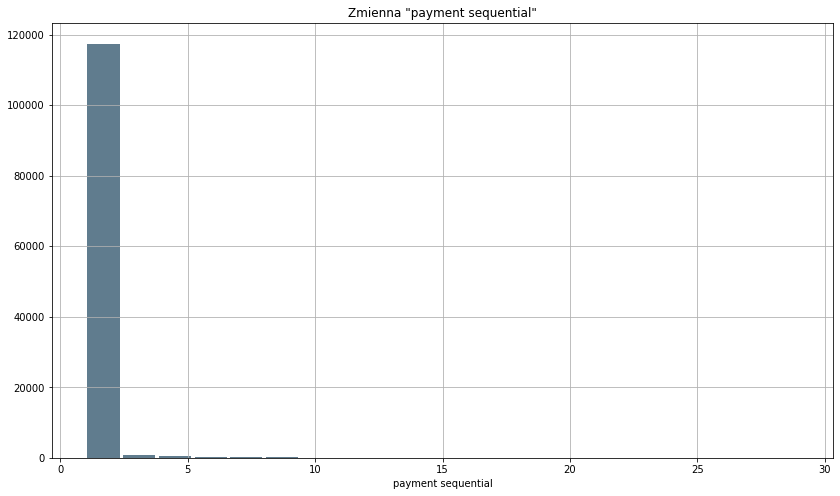

In [ ]:
fig = plt.figure()
data.payment_sequential.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e', figsize=(14,8))
plt.title('Zmienna "payment sequential"')
plt.xlabel('payment sequential')
plt.plot()
plt.show()
fig.savefig('payment_sequential.pdf')

In [ ]:
data.payment_sequential.value_counts().head(10)

1.0     114007
2.0       3415
3.0        658
4.0        322
5.0        194
6.0        136
7.0         94
8.0         63
9.0         51
10.0        42
Name: payment_sequential, dtype: int64

In [ ]:
# keep only delivered records and one sequential payments 
data = data[data.order_status == "delivered"]
data = data[data.payment_sequential == 1]

In [ ]:
# features selection
features = ['order_purchase_timestamp','payment_type','payment_installments','payment_value','product_id','price','product_name_lenght','product_description_lenght','product_photos_qty','customer_city','customer_state','product_category_name_english','review_score']
data = data[features]
data.head()

order_purchase_timestamp  ... review_score
0      2017-10-02 10:56:33  ...          4.0
3      2017-08-15 18:29:31  ...          4.0
4      2017-08-02 18:24:47  ...          5.0
5      2017-10-23 23:26:46  ...          3.0
6      2018-07-24 20:41:37  ...          4.0

[5 rows x 13 columns]

In [ ]:
data.loc[:,['payment_installments','payment_value','price','product_name_lenght','product_photos_qty','review_score']].describe().T

count        mean         std  ...    50%    75%       max
payment_installments  110757.0    3.018933    2.803906  ...    2.0    4.0     24.00
payment_value         110757.0  176.638979  269.715655  ...  112.3  192.9  13664.08
price                 110757.0  119.812207  181.986918  ...   74.9  133.9   6735.00
product_name_lenght   109215.0   48.810118   10.007767  ...   52.0   57.0     76.00
product_photos_qty    109215.0    2.207792    1.719760  ...    1.0    3.0     20.00
review_score          110757.0    4.066425    1.359203  ...    5.0    5.0      5.00

[6 rows x 8 columns]

In [ ]:
data.loc[:,['payment_type','product_id','customer_city','customer_state','product_category_name_english']].describe().T

count  ...   freq
payment_type                   110757  ...  85015
product_id                     110757  ...    520
customer_city                  110757  ...  17519
customer_state                 110757  ...  46683
product_category_name_english  109193  ...  11103

[5 rows x 4 columns]

In [ ]:
# clean data from missings
data.isna().sum()

order_purchase_timestamp            0
payment_type                        0
payment_installments                0
payment_value                       0
product_id                          0
price                               0
product_name_lenght              1542
product_description_lenght       1542
product_photos_qty               1542
customer_city                       0
customer_state                      0
product_category_name_english    1564
review_score                        0
dtype: int64

In [ ]:
data = data.dropna()
data.shape

(109193, 13)

In [ ]:
for f in features:
    print(f ,len(data[f].unique()))

order_purchase_timestamp 94548
payment_type 4
payment_installments 23
payment_value 27545
product_id 31604
price 5785
product_name_lenght 65
product_description_lenght 2944
product_photos_qty 19
customer_city 4073
customer_state 27
product_category_name_english 71
review_score 5


Payment value

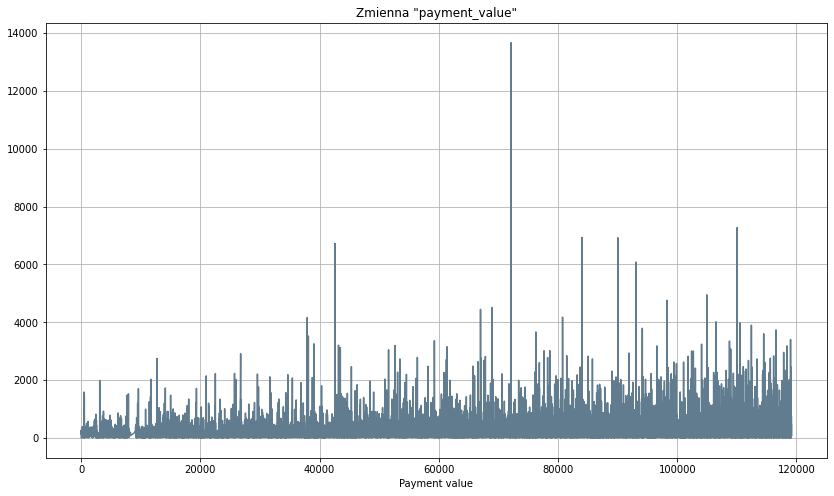

In [ ]:
fig = plt.figure()
data['payment_value'].plot(grid=True,color='#607c8e',figsize=(14,8))
plt.title('Zmienna "payment_value"')
plt.xlabel('Payment value')
plt.plot()
plt.show()
fig.savefig('payment_value.pdf')

<Figure size 432x288 with 0 Axes>

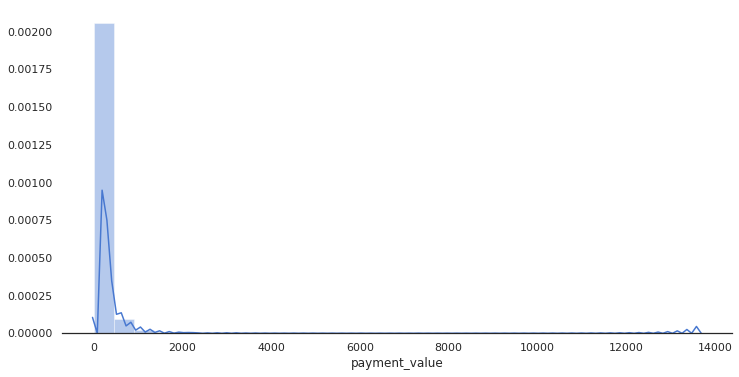

In [ ]:
fig = plt.figure()
sns.set(palette='muted', color_codes=True, style='white')
fig, ax = plt.subplots(figsize=(12, 6))
sns.despine(left=True)
sns.distplot(data.payment_value, bins=30)
plt.show()
fig.savefig("payment_value_dens.pdf")

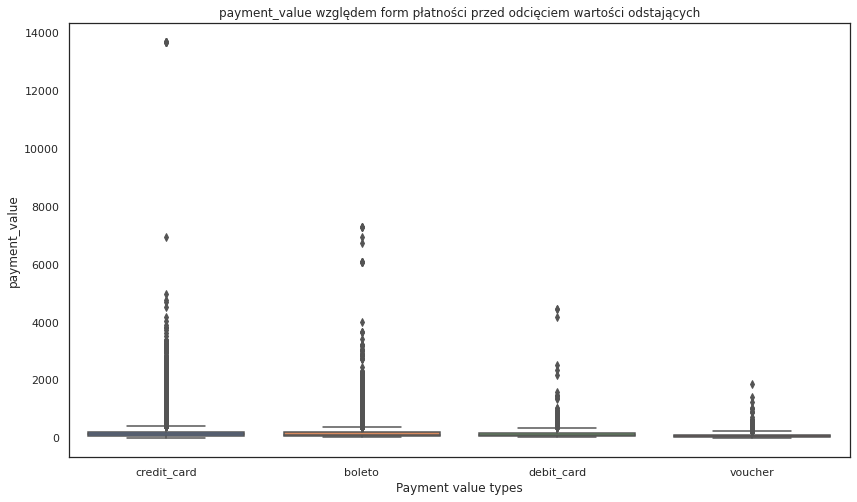

In [ ]:
plt.figure(figsize=(14,8))
sns.boxplot(data.payment_type,data.payment_value,linewidth=1.5)
plt.title('payment_value względem form płatności przed odcięciem wartości odstających')
plt.xlabel('Payment value types')
plt.savefig('chart.png')

In [ ]:
Q1 = data['payment_value'].quantile(0.25)
Q3 = data['payment_value'].quantile(0.75)
IQR = Q3 - Q1
len(data[(data['payment_value'] < (Q1 - 1.5 * IQR)) | (data['payment_value'] > (Q3 + 1.5 * IQR))])

8849

In [ ]:
o_pay = data[(data['payment_value'] < (Q1 - 1.5 * IQR)) | (data['payment_value'] > (Q3 + 1.5 * IQR))].index
data.drop(o_pay, inplace=True)
data.shape

(100344, 13)

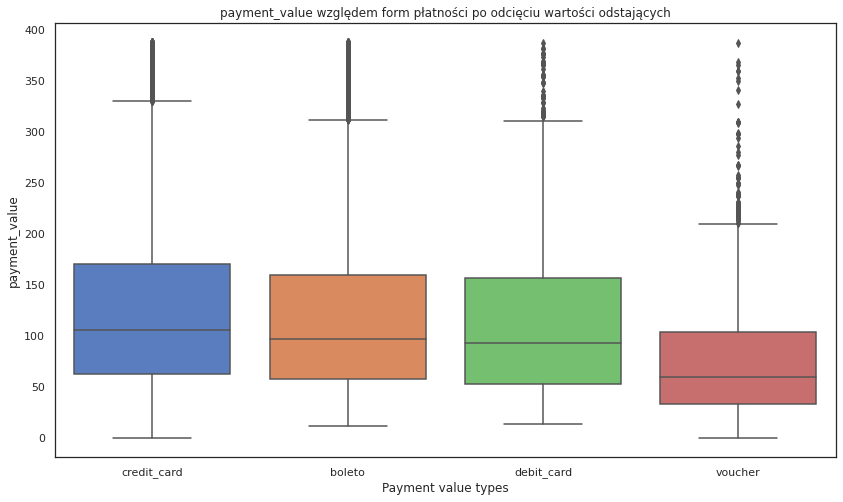

In [ ]:
fig = plt.figure(figsize=(14,8))
sns.boxplot(data.payment_type,data.payment_value,linewidth=1.5)
plt.title('payment_value względem form płatności po odcięciu wartości odstających')
plt.xlabel('Payment value types')
plt.plot()
fig.savefig('payment_value_types.pdf')

<Figure size 432x288 with 0 Axes>

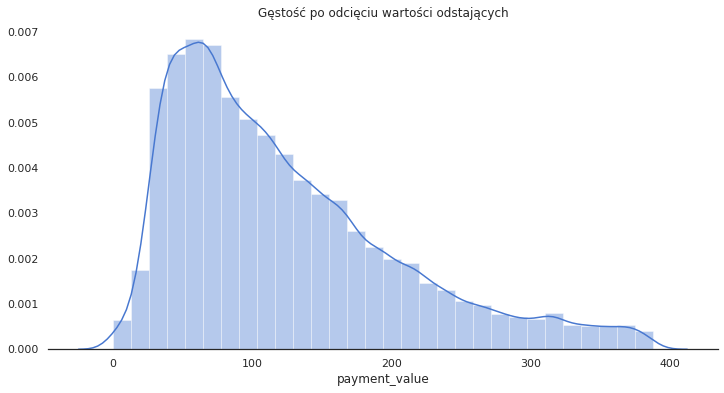

In [ ]:
fig = plt.figure()
sns.set(palette='muted', color_codes=True, style='white')
fig, ax = plt.subplots(figsize=(12, 6))
sns.despine(left=True)
sns.distplot(data.payment_value, bins=30)
plt.title('Gęstość po odcięciu wartości odstających')
plt.show()
fig.savefig("payment_value_dens_after.pdf")

review score

In [ ]:
for e in enumerate(data["review_score"].unique()):
    print(e)

(0, 4.0)
(1, 5.0)
(2, 3.0)
(3, 1.0)
(4, 2.0)


product_category_name_english

In [ ]:
cat = data.groupby("product_category_name_english")["product_category_name_english"].count().sort_values(ascending=False)
cat.head()

product_category_name_english
bed_bath_table           10555
health_beauty             8760
sports_leisure            8011
furniture_decor           7719
computers_accessories     6910
Name: product_category_name_english, dtype: int64

customer state

In [ ]:
data.customer_state.value_counts().head(10)

SP    42909
RJ    12879
MG    11834
RS     5589
PR     5083
SC     3713
BA     3263
DF     2147
ES     2066
GO     2005
Name: customer_state, dtype: int64

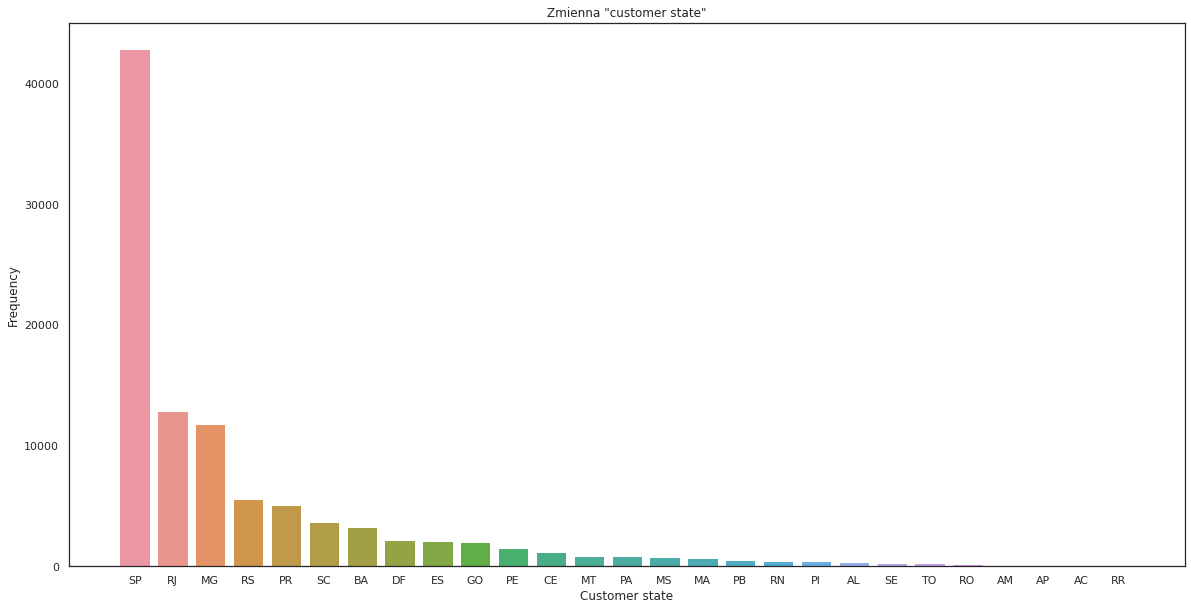

In [ ]:
plt.figure(figsize=(20,10))
cs = data['customer_state'].value_counts()
sns.barplot(cs.index,cs.values)
plt.title('Zmienna "customer state"')
plt.xlabel('Customer state')
plt.ylabel('Frequency')
plt.plot()
plt.savefig("customer_state.pdf")

Wybór zmiennych do modelu

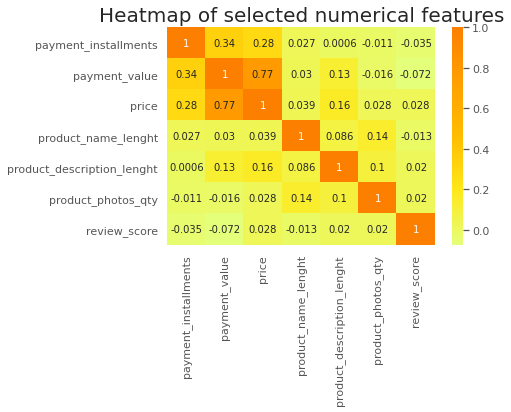

In [ ]:
fig = plt.figure()
plt.rcParams['figure.figsize'] = (20, 15)
plt.style.use('ggplot')

sns.heatmap(data.corr(), annot = True, cmap = 'Wistia')
plt.title('Heatmap of selected numerical features', fontsize = 20)
plt.show()
fig.savefig("heatmap.pdf")


In [ ]:
df = data.loc[:,['payment_value','product_description_lenght','order_purchase_timestamp']]
df = df.reset_index(drop=True)
df.head()

payment_value  product_description_lenght order_purchase_timestamp
0          18.12                       268.0      2017-10-02 10:56:33
1          37.77                       268.0      2017-08-15 18:29:31
2          37.77                       268.0      2017-08-02 18:24:47
3          44.09                       268.0      2017-10-23 23:26:46
4         141.46                       178.0      2018-07-24 20:41:37

Utworzenie nowej zmiennej "month"

In [ ]:
df['purchase_date'] = pd.to_datetime(df['order_purchase_timestamp']).dt.to_period('M')
df['month'] = df['purchase_date'].dt.month
df = df.drop(columns='purchase_date')
df = df.drop(columns='order_purchase_timestamp')
df.head()

payment_value  product_description_lenght  month
0          18.12                       268.0     10
1          37.77                       268.0      8
2          37.77                       268.0      8
3          44.09                       268.0     10
4         141.46                       178.0      7

##### Clustering 1

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

data_good = df.copy()
data_good.iloc[:,:-1] = scaler.fit_transform(data_good.iloc[:,:-1])
df_good = pd.DataFrame(data_good, columns=['payment_value','product_description_lenght','month'])
df_good.head()

payment_value  product_description_lenght  month
0      -1.288030                    -0.78604     10
1      -1.048143                    -0.78604      8
2      -1.048143                    -0.78604      8
3      -0.970989                    -0.78604     10
4       0.217700                    -0.92876      7

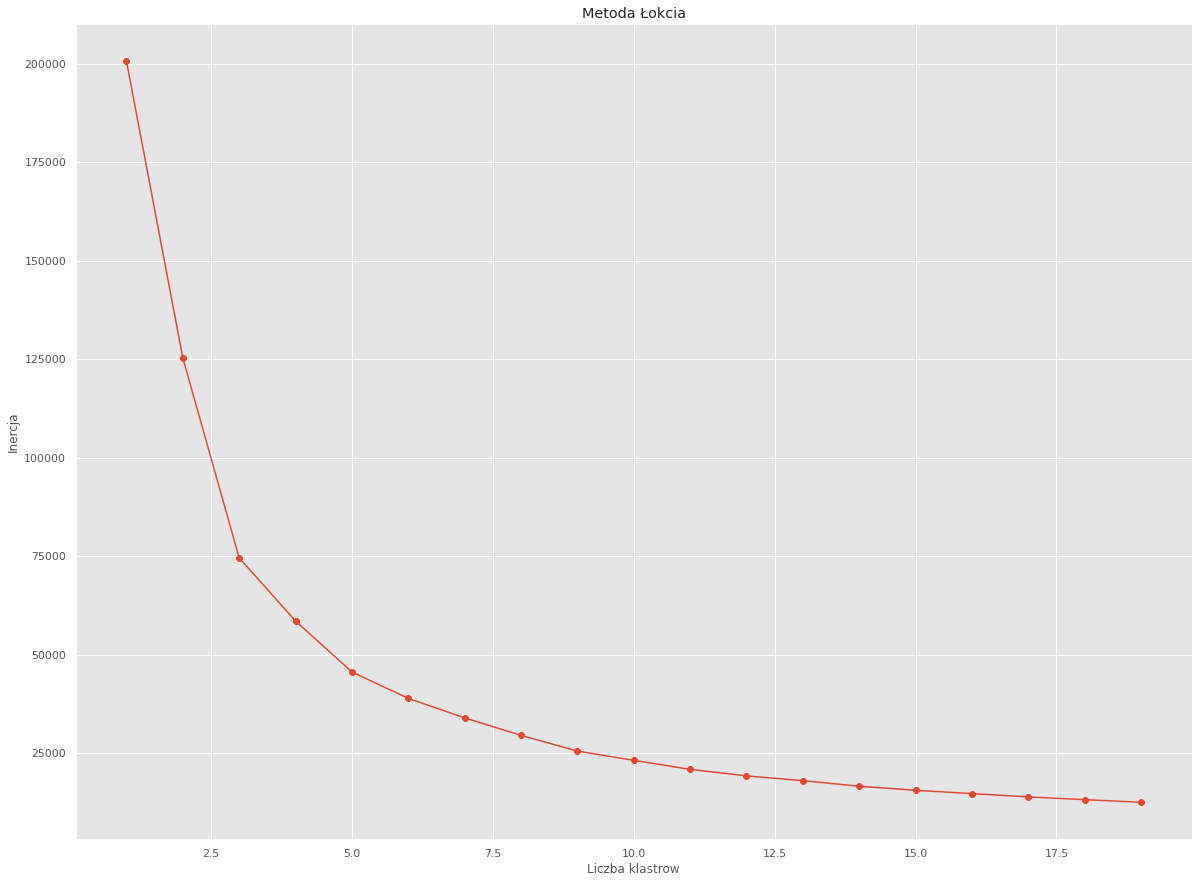

In [ ]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 20):
    kmeans = KMeans(n_jobs = -1, n_clusters=i, init='k-means++', max_iter=100, n_init=10, random_state=0)
    kmeans.fit(df_good.iloc[:,:-1])
    wcss.append(kmeans.inertia_)

fig = plt.figure()
plt.plot(range(1, 20), wcss, marker='8')
plt.title('Metoda Łokcia')
plt.xlabel('Liczba klastrow')
plt.ylabel('Inercja')
plt.show()
fig.savefig("Inercja_C1.pdf")

In [ ]:
kmeans = KMeans(n_clusters=5, init='k-means++',n_init=100, 
            max_iter=3000, random_state=0, n_jobs=4)

clusters = kmeans.fit_predict(df_good.iloc[:,:-1])
df_good['Cluster'] = clusters
df_good.head()

payment_value  product_description_lenght  month  Cluster
0      -1.288030                    -0.78604     10        1
1      -1.048143                    -0.78604      8        1
2      -1.048143                    -0.78604      8        1
3      -0.970989                    -0.78604     10        1
4       0.217700                    -0.92876      7        4

In [ ]:
centers = kmeans.cluster_centers_
print(centers)

[[ 2.06259634  0.00666214]
 [-0.73677489 -0.5353039 ]
 [ 0.41670088  2.88983415]
 [-0.35360534  0.70261704]
 [ 0.53040687 -0.40730251]]


In [ ]:
clust = pd.DataFrame(clusters)
clust[0].value_counts()

1    41113
4    23289
3    18997
0    10684
2     6261
Name: 0, dtype: int64

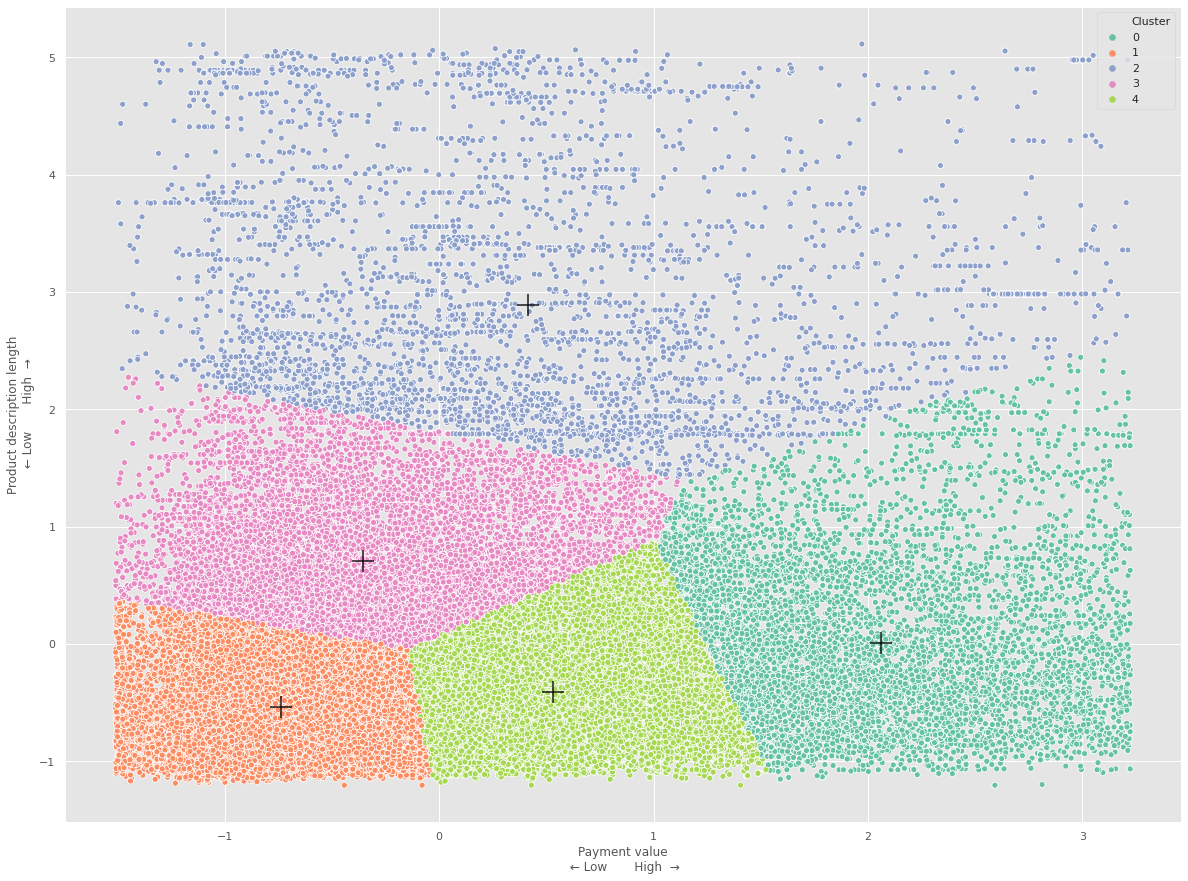

In [ ]:
fig = plt.figure()
rys = sns.scatterplot(x='payment_value', y='product_description_lenght', data=df_good,
               hue='Cluster', palette='Set2')
rys.set(xlabel = 'Payment value\n ← Low       High  →', ylabel = 'Product description length\n ← Low       High  →')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=500, alpha=0.9, marker ='+')
plt.plot()
fig.savefig("Kmeans_C1.pdf", dpi=300)

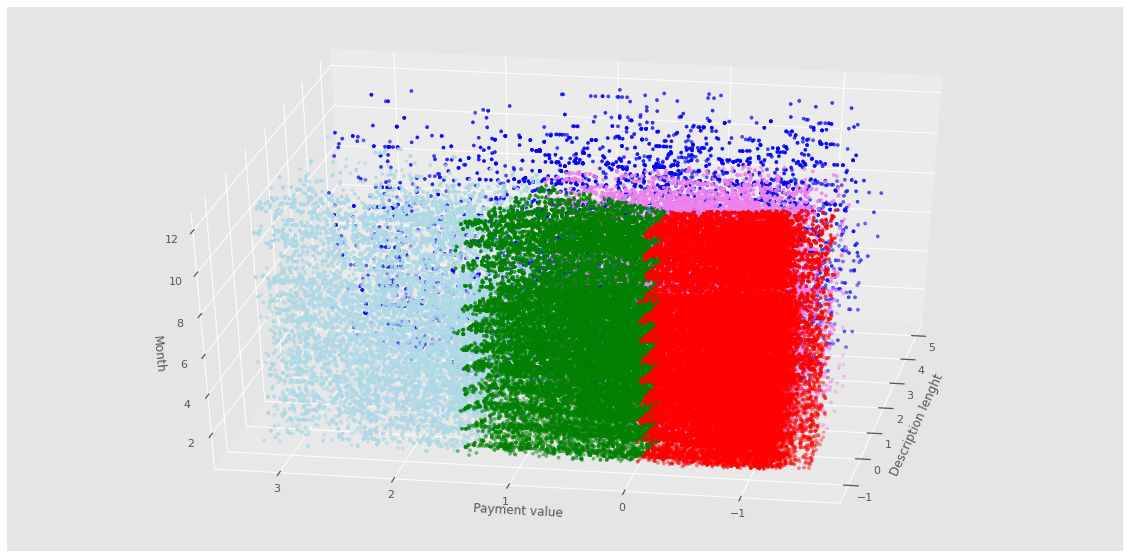

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_good["product_description_lenght"][df_good.Cluster == 0], df_good["payment_value"][df_good.Cluster == 0], df_good["month"][df_good.Cluster == 0], c='lightblue', s=10)
ax.scatter(df_good["product_description_lenght"][df_good.Cluster == 1], df_good["payment_value"][df_good.Cluster == 1], df_good["month"][df_good.Cluster == 1], c='red', s=10)
ax.scatter(df_good["product_description_lenght"][df_good.Cluster == 2], df_good["payment_value"][df_good.Cluster == 2], df_good["month"][df_good.Cluster == 2], c='blue', s=10)
ax.scatter(df_good["product_description_lenght"][df_good.Cluster == 3], df_good["payment_value"][df_good.Cluster == 3], df_good["month"][df_good.Cluster == 3], c='violet', s=10)
ax.scatter(df_good["product_description_lenght"][df_good.Cluster == 4], df_good["payment_value"][df_good.Cluster == 4], df_good["month"][df_good.Cluster == 4], c='green', s=10)

ax.view_init(35, 190)
plt.xlabel("Description lenght")
plt.ylabel("Payment value")
ax.set_zlabel("Month")
plt.show()
fig.savefig("Kmeans_C1_3dpreview.pdf", dpi=300)

##### Clustering 2

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

data_good2 = df.copy()
data_good2 = scaler.fit_transform(data_good2)
df_good2 = pd.DataFrame(data_good2, columns=['payment_value','product_description_lenght','month'])
df_good2.head()

payment_value  product_description_lenght     month
0      -1.288030                    -0.78604  1.227628
1      -1.048143                    -0.78604  0.608179
2      -1.048143                    -0.78604  0.608179
3      -0.970989                    -0.78604  1.227628
4       0.217700                    -0.92876  0.298455

In [ ]:
df_good2.describe().T

count          mean  ...       75%       max
payment_value               100344.0 -3.369388e-16  ...  0.524852  3.223789
product_description_lenght  100344.0 -1.258660e-17  ...  0.300211  5.113021
month                       100344.0 -1.857581e-15  ...  0.608179  1.847076

[3 rows x 8 columns]

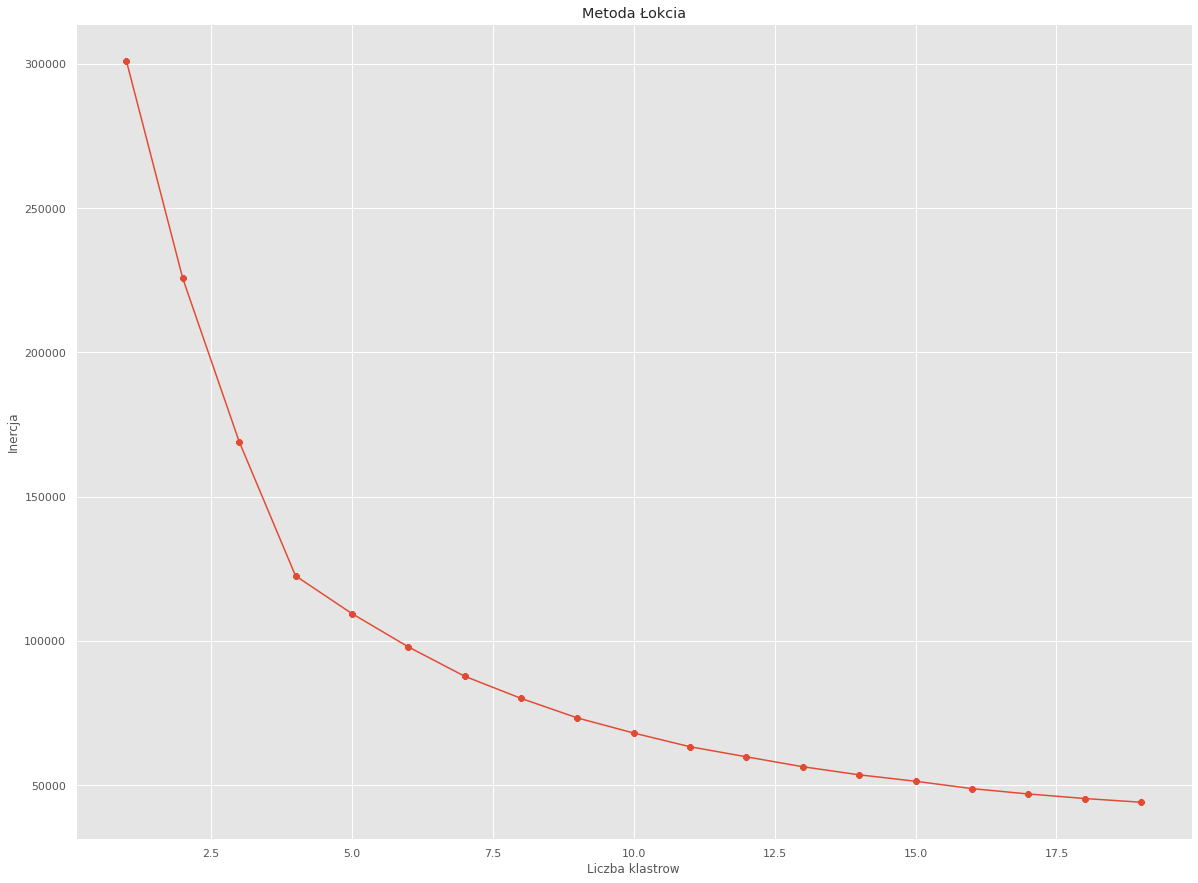

In [ ]:
wcss = []
for i in range(1, 20):
    kmeans = KMeans(n_jobs = -1, n_clusters=i, init='k-means++', max_iter=100, n_init=10, random_state=0)
    kmeans.fit(data_good2)
    wcss.append(kmeans.inertia_)

fig = plt.figure()
plt.plot(range(1, 20), wcss, marker='8')
plt.title('Metoda Łokcia')
plt.xlabel('Liczba klastrow')
plt.ylabel('Inercja')
plt.show()
fig.savefig("Inercja_C2.pdf")

In [ ]:
kmeans = KMeans(n_clusters=4, init='k-means++',n_init=100, 
            max_iter=3000, random_state=0, n_jobs=4)

clusters = kmeans.fit_predict(data_good2)
df_good2['Cluster'] = clusters
df_good2.head()

payment_value  product_description_lenght     month  Cluster
0      -1.288030                    -0.78604  1.227628        2
1      -1.048143                    -0.78604  0.608179        2
2      -1.048143                    -0.78604  0.608179        2
3      -0.970989                    -0.78604  1.227628        2
4       0.217700                    -0.92876  0.298455        2

In [ ]:
clust2 = pd.DataFrame(clusters)
clust2[0].value_counts()

1    39992
2    32991
3    18160
0     9201
Name: 0, dtype: int64

In [ ]:
centers = kmeans.cluster_centers_
print(centers)

[[ 0.26795814  2.44782485 -0.05562601]
 [-0.45637405 -0.26644009 -0.77441603]
 [-0.40036703 -0.27809132  0.99645896]
 [ 1.59597246 -0.15065558 -0.07708568]]


In [ ]:
trace = go.Scatter3d(
    x = df_good2['month'],
    y = df_good2["payment_value"],
    z = df_good2["product_description_lenght"],
    mode='markers',
     marker=dict(
        color = df_good2.Cluster, 
        size= 1,
        colorscale='Viridis',
        line=dict(
            color= df_good2['Cluster'],
            width= 1
        ),
        opacity=0.8
     )
)

rys = [trace]
layout = go.Layout(
     margin=dict(l=0,r=0,b=0,t=0),title= 'Clusters',
    scene = dict(
            xaxis = dict(title  = 'month'),
            yaxis = dict(title  = 'Payment value'),
            zaxis = dict(title  = 'description_lenght')
        )
)
fig = go.Figure(data=rys, layout=layout)
fig.show()